<a href="https://colab.research.google.com/github/datascience-uniandes/hypothesis-testing-tutorial/blob/master/hypothesis-testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML - Supermercados Inteligentes

Univerisdad de los Andes MINE-4101: Applied Data Science  

- Lizeth Viviana Perdomo Castañeda
- David Esteban Fajardo Torres
  
**Dataset:** Dataset abierto de varios productos de mercado con sus etiquetas para identificar el tipo de productos. [dataset](https://github.com/marcusklasson/GroceryStoreDataset/tree/master/dataset).

**Business Context:** Los supermercados inteligentes están diseñados para mejorar todos los aspectos del proceso de compra, desde la entrada del cliente hasta la salida, utilizando tecnologías avanzadas para automatizar tareas, gestionar inventarios en tiempo real y analizar el comportamiento del consumidor.

Un nuevo supermercado inteligente, ha implementado tecnologías avanzadas como sensores y cámaras. Para iniciar la automatización de procesos, ahora necesita aprovechar mejor los datos generados a diario para tomar decisiones más informadas y eficaces.

El supermercado requiere el desarrollo de un sistema de automatización que permita a los clientes tomar productos y salir sin pasar por caja, mientras las cámaras y sensores registran automáticamente los artículos seleccionados.


In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

### Carga y exploración del Dataset

In [3]:
base_dir = r'C:\Users\lperd\OneDrive - Universidad de los andes\MINE 2024-2\CIENCIA DE DATOS APLICADA\Talleres\Taller 2\GroceryStoreDataset\dataset'

In [4]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [5]:
# Crear un generador para cargar las imágenes
datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Found 2485 images belonging to 3 classes.


In [6]:
def mostrar_imagenes(generator, num_images=5):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()

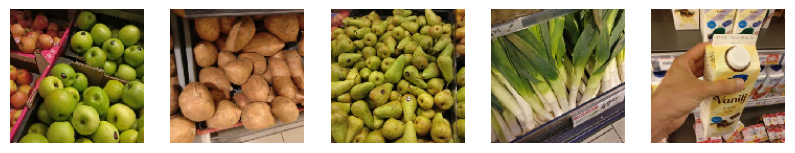

In [7]:
mostrar_imagenes(train_generator)

In [8]:
# Aumento de datos
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

### Entrenamiento del modelo de Machine Learning

In [10]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10

In [11]:
# Modelo CNN básico
def crear_modelo_baseline():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Entrenar el modelo CNN básico
modelo_baseline = crear_modelo_baseline()
history_baseline = modelo_baseline.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

c:\Users\lperd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\lperd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 422ms/step - accuracy: 0.5790 - loss: 0.9410 - val_accuracy: 0.5743 - val_loss: 0.9196
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 205ms/step - accuracy: 0.7324 - loss: 0.6160 - val_accuracy: 0.6419 - val_loss: 0.8530
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - accuracy: 0.7711 - loss: 0.5205 - val_accuracy: 0.6655 - val_loss: 0.8487
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.8116 - loss: 0.4360 - val_accuracy: 0.6385 - val_loss: 0.9666
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 193ms/step - accuracy: 0.8228 - loss: 0.3899 - val_accuracy: 0.7162 - val_loss: 0.8579
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - accuracy: 0.8800 - loss: 0.2840 - val_accuracy: 0.7128 - val_loss: 0.8268
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 189ms/step - accuracy: 0.9035 - loss: 0.2409 - val_accuracy: 0.7365 - val_loss: 0.9153
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - accuracy: 0.9240 - loss: 0.1936 - val_accu

In [13]:
# Modelo de Transfer Learning con MobileNetV2
def crear_modelo_transfer():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base_model.trainable = False  # Congelar las capas de MobileNetV2
    
    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
# Entrenar el modelo de Transfer Learning
modelo_transfer = crear_modelo_transfer()
history_transfer = modelo_transfer.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 237ms/step - accuracy: 0.8277 - loss: 0.4767 - val_accuracy: 0.9392 - val_loss: 0.1404
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - accuracy: 0.9568 - loss: 0.1195 - val_accuracy: 0.9527 - val_loss: 0.1244
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - accuracy: 0.9783 - loss: 0.0567 - val_accuracy: 0.9527 - val_loss: 0.1052
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 221ms/step - accuracy: 0.9922 - loss: 0.0386 - val_accuracy: 0.9561 - val_loss: 0.1396
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - accuracy: 0.9910 - loss: 0.0288 - val_accuracy: 0.9561 - val_loss: 0.1340
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - accuracy: 0.9953 - loss: 0.0218 - val_accuracy: 0.9459 - val_loss: 0.1693
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - accuracy: 0.9909 - loss: 0.0247 - val_accuracy: 0.9561 - val_loss: 0.1224
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 230ms/

### Evaluación de los modelos

In [15]:
print("Evaluación del modelo CNN básico:")
baseline_eval = modelo_baseline.evaluate(test_generator)

print("\nEvaluación del modelo Transfer Learning:")
transfer_eval = modelo_transfer.evaluate(test_generator)

Evaluación del modelo CNN básico:
78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step - accuracy: 0.8048 - loss: 0.6981

Evaluación del modelo Transfer Learning:
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.9635 - loss: 0.1054
